In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
# from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import imageio
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sn
from keras.utils import to_categorical
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
# import diffimageml

/home/fkirmani/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
x1 = []
im_even = [fn for fn in glob.glob("./lco_data/MEFbatch/class_fp/*.png") if "0.png" in fn or "2.png" in fn or "4.png" in fn or "6.png" in fn or "8.png" in fn]
for fn in im_even:
    im = imageio.imread(fn)
    x1.append(im)

In [3]:
x2 = []
im_even = [fn for fn in glob.glob("./lco_data/MEFbatch/class_single/images/*.png") if "0.png" in fn or "2.png" in fn or "4.png" in fn or "6.png" in fn or "8.png" in fn]
for fn in glob.glob('./lco_data/MEFbatch/class_single/images/*.png'):
    im = imageio.imread(fn)
    x2.append(im)

In [4]:
x3 = []
im_even = [fn for fn in glob.glob("./lco_data/MEFbatch/class_lensed/images/*.png") if "0.png" in fn or "2.png" in fn or "4.png" in fn or "6.png" in fn or "8.png" in fn]
for fn in glob.glob('./lco_data/MEFbatch/class_lensed/images/*.png'):
    im = imageio.imread(fn)
    x3.append(im)

In [5]:
y1=[]
for i in enumerate(x1):
    y1.append(0)

In [6]:
y2=[]
for i in enumerate(x2):
    y2.append(1)

In [7]:
y3=[]
for i in enumerate(x3):
    y3.append(2)

In [8]:
x = [] 
x.extend(x1)
x.extend(x2)
x.extend(x3)
# x = np.expand_dims(x, axis=1)
x = np.array(x)

In [9]:
y = [] 
y.extend(y1)
y.extend(y2)
y.extend(y3)
y = to_categorical(y, num_classes=3)
y = np.array(y)

#### Approach 1 - Training our own VGG16 model from scratch

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.1)

In [11]:
X_train.shape

(49248, 50, 50, 3)

In [12]:
model = Sequential()
model.add(Conv2D(input_shape=(50,50,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=4,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=32,activation="relu"))
model.add(Dense(units=32,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

In [13]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy', 
                       tf.keras.metrics.AUC(num_thresholds=1200, curve='ROC', summation_method='interpolation')])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 4)         2308      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)         296       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 16)        1

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_auc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='val_auc', min_delta=0, patience=5, verbose=1, mode='max')
# hist = model.fit_generator(steps_per_epoch=10,generator=(X_train, y_train), validation_data= (X_test, y_test), validation_steps=10,epochs=50,callbacks=[checkpoint,early])
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32,callbacks=[checkpoint,early])

Epoch 1/50
1539/1539 [==============================] - 90s 58ms/step - loss: 0.8139 - accuracy: 0.6115 - auc: 0.7869 - val_loss: 0.5682 - val_accuracy: 0.7230 - val_auc: 0.8834

Epoch 00001: val_auc improved from -inf to 0.88338, saving model to vgg16_1.h5
Epoch 2/50
1539/1539 [==============================] - 87s 56ms/step - loss: 0.5462 - accuracy: 0.7260 - auc: 0.8879 - val_loss: 0.5293 - val_accuracy: 0.7367 - val_auc: 0.8923

Epoch 00002: val_auc improved from 0.88338 to 0.89225, saving model to vgg16_1.h5
Epoch 3/50
1539/1539 [==============================] - 88s 57ms/step - loss: 0.5444 - accuracy: 0.7223 - auc: 0.8864 - val_loss: 0.5520 - val_accuracy: 0.7285 - val_auc: 0.8880

Epoch 00003: val_auc did not improve from 0.89225
Epoch 4/50
1539/1539 [==============================] - 87s 56ms/step - loss: 0.5298 - accuracy: 0.7296 - auc: 0.8913 - val_loss: 0.5590 - val_accuracy: 0.7276 - val_auc: 0.8873

Epoch 00004: val_auc did not improve from 0.89225
Epoch 5/50
1539/1539 [=

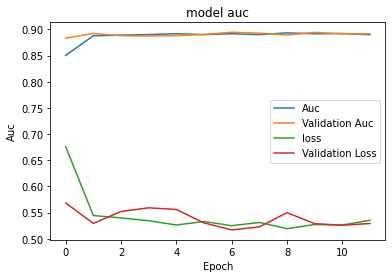

In [16]:
plt.plot(hist.history["auc"])
plt.plot(hist.history['val_auc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model auc")
plt.ylabel("Auc")
plt.xlabel("Epoch")
plt.legend(["Auc","Validation Auc","loss","Validation Loss"])
plt.savefig("trainvalid.png")

In [17]:
model = load_model('./vgg16_1.h5')

In [18]:
model_pred = model.predict(X_test, batch_size=32, verbose=1)
model_predicted = np.argmax(model_pred, axis=1)

172/172 [==============================] - 2s 10ms/step


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_predicted) 
model_cm

array([[1085,    0,   11],
       [   4,    0, 1407],
       [  11,    0, 2955]])

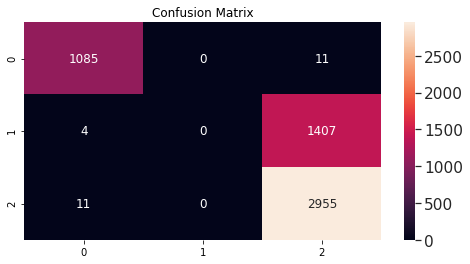

In [20]:
model_df_cm = pd.DataFrame(model_cm, range(3), range(3)) 
plt.figure(figsize = (8, 4)) 
plt.title('Confusion Matrix')
sn.set(font_scale=1.4) #for label size 
sn.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}, fmt="d") # font size 
plt.show()

In [21]:
model_report = classification_report(np.argmax(y_test, axis=1), model_predicted)
print(model_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1096
           1       0.00      0.00      0.00      1411
           2       0.68      1.00      0.81      2966

    accuracy                           0.74      5473
   macro avg       0.55      0.66      0.60      5473
weighted avg       0.56      0.74      0.63      5473



/home/fkirmani/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
